In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.impute import KNNImputer

from pyspark.sql import SparkSession
from pyspark.ml  import Pipeline
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.window import Window
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit, input_file_name, desc
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, QuantileDiscretizer, VectorIndexer, Imputer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Summarizer


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Create SparkSession
spark = (SparkSession.builder.appName('child_mind_institute_data').getOrCreate())

In [5]:
data_path = '.'


train = spark.read.csv(f'{data_path}/train.csv', inferSchema=True, header=True)
test = spark.read.csv(f'{data_path}/test.csv', inferSchema=True, header=True)

# **Data Overview**

## HBN Instruments

In [6]:
# See which features have missing values and how many missing values
# after removing the missing values of target label 'sii'

supervised_usable = train.filter(train['sii'].isNotNull())

missing_count = []
for col_name in supervised_usable.columns:
    null_count = supervised_usable.filter(supervised_usable[col_name].isNull()).count()

    null_ratio = null_count / supervised_usable.count() if supervised_usable.count() > 0 else 0
    missing_count.append((col_name, null_count, null_ratio))

missing_count_df = spark.createDataFrame(missing_count, ['feature', 'null_count', 'null_ratio'])

missing_count_df = missing_count_df.orderBy(F.col('null_count').desc())

missing_count_df.show()

+--------------------+----------+-------------------+
|             feature|null_count|         null_ratio|
+--------------------+----------+-------------------+
|        PAQ_A-Season|      2373| 0.8673245614035088|
|   PAQ_A-PAQ_A_Total|      2373| 0.8673245614035088|
|Physical-Waist_Ci...|      2253| 0.8234649122807017|
|Fitness_Endurance...|      2008| 0.7339181286549707|
|Fitness_Endurance...|      2008| 0.7339181286549707|
|Fitness_Endurance...|      2005| 0.7328216374269005|
|   FGC-FGC_GSND_Zone|      1872| 0.6842105263157895|
|    FGC-FGC_GSD_Zone|      1872| 0.6842105263157895|
|         FGC-FGC_GSD|      1865| 0.6816520467836257|
|        FGC-FGC_GSND|      1864| 0.6812865497076024|
|Fitness_Endurance...|      1476| 0.5394736842105263|
|        PAQ_C-Season|      1296|0.47368421052631576|
|   PAQ_C-PAQ_C_Total|      1296|0.47368421052631576|
|         BIA-BIA_BMC|       923|0.33735380116959063|
|         BIA-BIA_FFM|       923|0.33735380116959063|
|         BIA-BIA_BMI|      

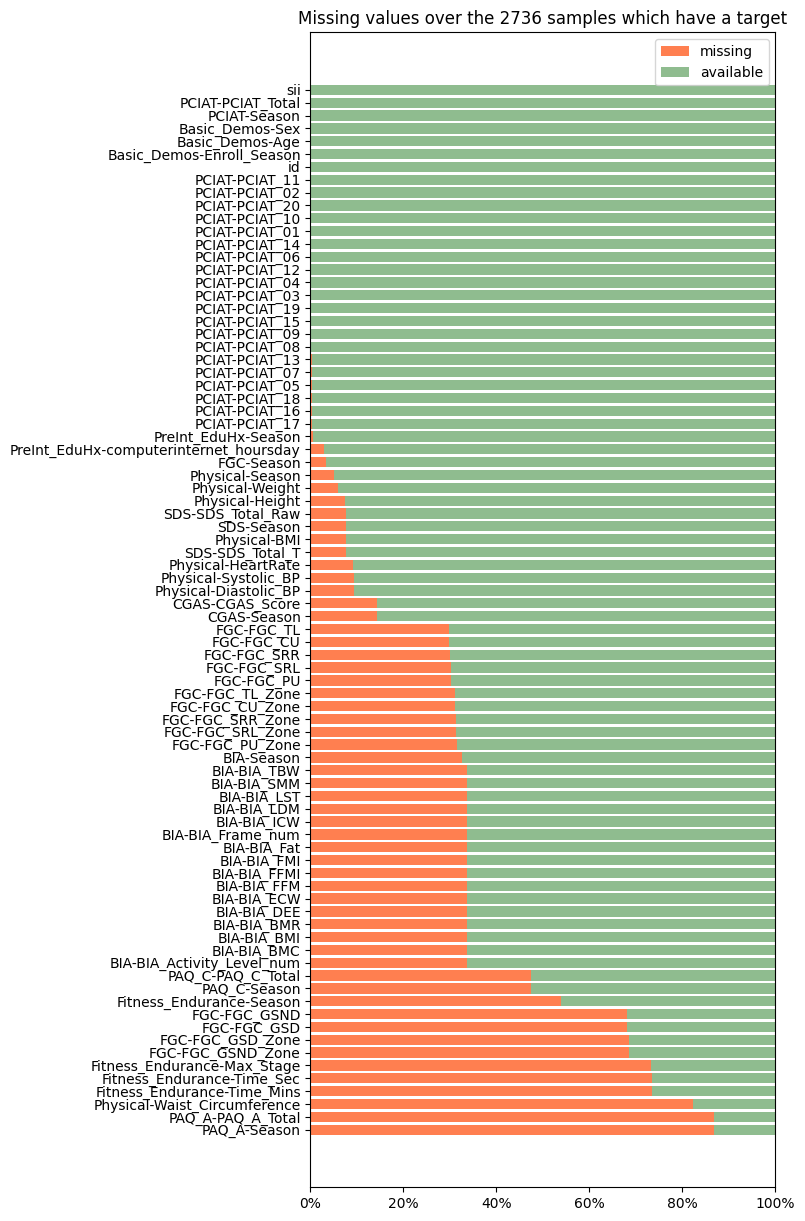

In [7]:
# Visualize the missing_count

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

missing_count_pandas = missing_count_df.toPandas()

plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {supervised_usable.count()} samples which have a target')

plt.barh(np.arange(len(missing_count_pandas)), missing_count_pandas['null_ratio'], color='coral', label='missing')

plt.barh(np.arange(len(missing_count_pandas)),
         1 - missing_count_pandas['null_ratio'],
         left = missing_count_pandas['null_ratio'],
         color='darkseagreen', label='available')

plt.yticks(np.arange(len(missing_count_pandas)), missing_count_pandas['feature'])
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()


In [8]:
# There is a direct correlation between 'PCIAT-PCIAT_Total' and 'sii'
# They either have missing values ​​or none at the same row

null_check = train.withColumn('null_match', (col('PCIAT-PCIAT_Total').isNull() == col('sii').isNull()).cast('int'))
matching_ratio = null_check.agg({'null_match': 'mean'}).collect()[0][0]
print(matching_ratio)

1.0


In [9]:
# 'PCIAT-PCIAT_Total': [0, 30] → 'sii': 0
# 'PCIAT-PCIAT_Total': [31, 49] → 'sii': 1
# 'PCIAT-PCIAT_Total': [50, 79] → 'sii': 2
# 'PCIAT-PCIAT_Total': [80, 100] → 'sii': 3

# Conclusion:
# 'PCIAT-PCIAT_Total' is a continuous label
# 'sii' is a discrete label

pciat_stats = train.groupBy('sii').agg(
    F.min('PCIAT-PCIAT_Total').alias('min'),
    F.max('PCIAT-PCIAT_Total').alias('max'),
    F.count('PCIAT-PCIAT_Total').alias('count'),
)
pciat_stats = pciat_stats.orderBy('sii')

pciat_stats.show()

+----+----+----+-----+
| sii| min| max|count|
+----+----+----+-----+
|NULL|NULL|NULL|    0|
|   0|   0|  30| 1594|
|   1|  31|  49|  730|
|   2|  50|  79|  378|
|   3|  80|  93|   34|
+----+----+----+-----+



In [10]:
# See which feature is in trainset but not in testset
# We cannot use these features while training
# It turns out that all the "PCIAT"-related features and the label in trainset are not in testset

train_columns = set(train.columns)
test_columns = set(test.columns)

missing_columns = list(train_columns - test_columns)

print('Columns missing in test')
print(missing_columns)

Columns missing in test
['PCIAT-Season', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_14', 'sii', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_05']


## Demographic

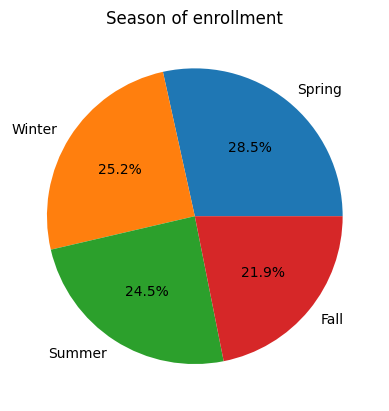

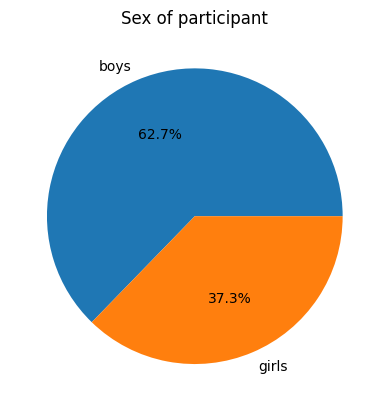

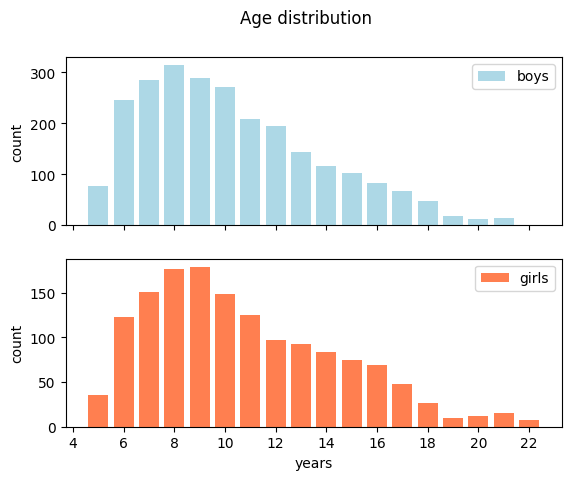

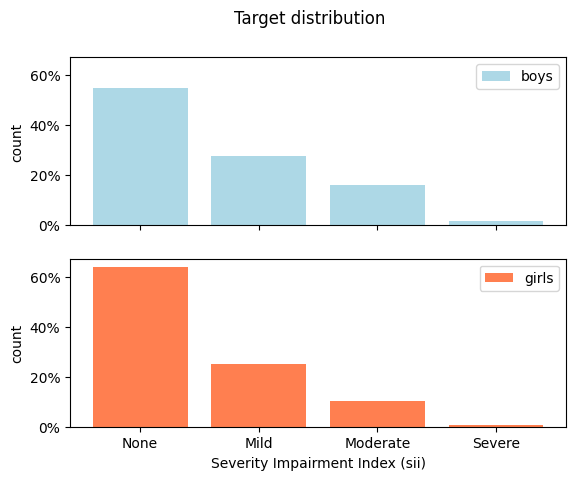

In [11]:
# Visualize some important features' distribution

train_pd = train.toPandas()

# Enroll Seasons
vc = train_pd['Basic_Demos-Enroll_Season'].value_counts()
plt.pie(vc, labels=vc.index, autopct='%1.1f%%')
plt.title('Season of enrollment')
plt.show()

# Enroll Sex
vc = train_pd['Basic_Demos-Sex'].value_counts()
plt.pie(vc, labels=['boys', 'girls'], autopct='%1.1f%%')
plt.title('Sex of participant')
plt.show()

# Age distribution
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    sex_data = train_pd[train_pd['Basic_Demos-Sex'] == sex]
    vc = sex_data['Basic_Demos-Age'].value_counts()
    ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['boys', 'girls'][sex])
    ax.set_ylabel('count')
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

# Target distribution
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
target_labels = ['None', 'Mild', 'Moderate', 'Severe']
for sex in range(2):
    ax = axs.ravel()[sex]
    sex_data = train_pd[train_pd['Basic_Demos-Sex'] == sex]
    vc = sex_data['sii'].value_counts(normalize=True)
    ax.bar(vc.index, vc.values, color=['lightblue', 'coral'][sex], label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

{'Basic_Demos-Age': 0.4095589300442593, 'Physical-BMI': 0.15114751746836297, 'Physical-Height': 0.1667743845043196, 'Physical-Weight': 0.29901804979726576, 'PreInt_EduHx-computerinternet_hoursday': 0.36522768449538073, 'SDS-SDS_Total_T': 0.15712431429762028, 'PAQ_A-PAQ_A_Total': 0.210394863608451, 'PAQ_C-PAQ_C_Total': 0.10243470123646388, 'Fitness_Endurance-Max_Stage': -0.11842935200737925, 'Fitness_Endurance-Time_Mins': -0.11958997715157199, 'FGC-FGC_CU': 0.1715539468499386, 'FGC-FGC_GSND': 0.2725834535666146, 'FGC-FGC_GSD': 0.2755155867903572, 'FGC-FGC_PU': 0.11492578301805696, 'FGC-FGC_SRL': -0.10784358025725917, 'FGC-FGC_SRR': -0.10301051532552276}


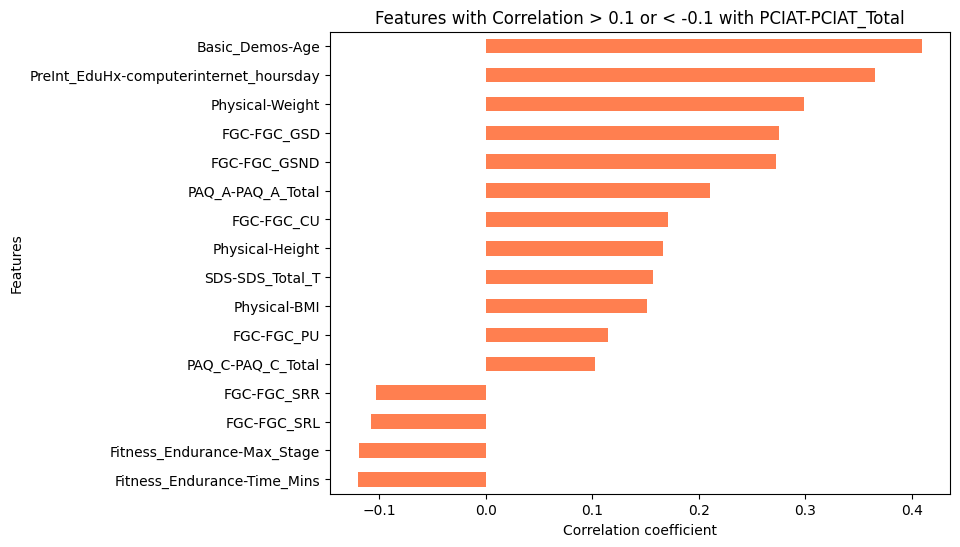

In [12]:
# Select some import features, see their correlation with the continuous label 'PCIAT-PCIAT_Total'

selected_columns = [
    'PCIAT-PCIAT_Total', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Physical-HeartRate',
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
    'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
    'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW',
]

corr_dict = {}
for col in selected_columns:
    if col != 'PCIAT-PCIAT_Total':
        corr = supervised_usable.stat.corr('PCIAT-PCIAT_Total', col)
        corr_dict[col] = corr

# If the correlation > 0.1 or < -0.1, visualize it.
filtered_corr = {col: corr for col,  corr in corr_dict.items() if corr > 0.1 or corr < -0.1}
print(filtered_corr)

filtered_corr_pd = pd.Series(filtered_corr).sort_values()
plt.figure(figsize=(8, 6))
filtered_corr_pd.plot(kind='barh', color='coral')
plt.title('Features with Correlation > 0.1 or < -0.1 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.show()

## Actigraphy Files (time series)

In [13]:
# Read only one actigraphy file and find something useful

actigraphy = spark.read.parquet(f'{data_path}/series_train.parquet/id=0417c91e/part-0.parquet')

In [14]:
# Visualize some features by time series

from matplotlib.ticker import MaxNLocator

def analyze_actigraphy(actigraphy, only_one_week=False, small=False):
    actigraphy = actigraphy.withColumn(
        'day', actigraphy['relative_date_PCIAT'] + actigraphy['time_of_day'] / 86400e9
    )

    sample = train.filter(train['id'] == '0417c91e').collect()
    age = sample[0]['Basic_Demos-Age']
    sex = ['boy', 'girl'][sample[0]['Basic_Demos-Sex']]

    window_spec = Window.orderBy('day')
    actigraphy = actigraphy.withColumn(
        'diff_seconds', (actigraphy['day'] - F.lag('day', 1).over(window_spec)) * 86400
    )

    actigraphy = actigraphy.withColumn(
        'norm', F.sqrt(actigraphy['X']**2 + actigraphy['Y']**2 + actigraphy['Z']**2)
    )

    if only_one_week:
        start = np.ceil(actigraphy.agg(F.min('day')).collect()[0][0])
        mask = (start <= actigraphy['day']) & (actigraphy['day'] <= start + 7 * 3)
        mask &= ~actigraphy['non-wear_flag'].cast('boolean')
    else:
        mask = F.lit(True)

    if small:
        timelines = [('enmo', 'forestgreen'), ('light', 'orange')]
    else:
        timelines = [
            ('X', 'm'), ('Y', 'm'), ('Z', 'm'),
            ('enmo', 'forestgreen'), ('anglez', 'lightblue'),
            ('light', 'orange'), ('non-wear_flag', 'chocolate')
        ]

    actigraphy = actigraphy.filter(mask)
    actigraphy_pd = actigraphy.toPandas()

    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(actigraphy_pd['day'], actigraphy_pd[feature], color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id=0417c91e, {sex}, age={age}')
    plt.show()

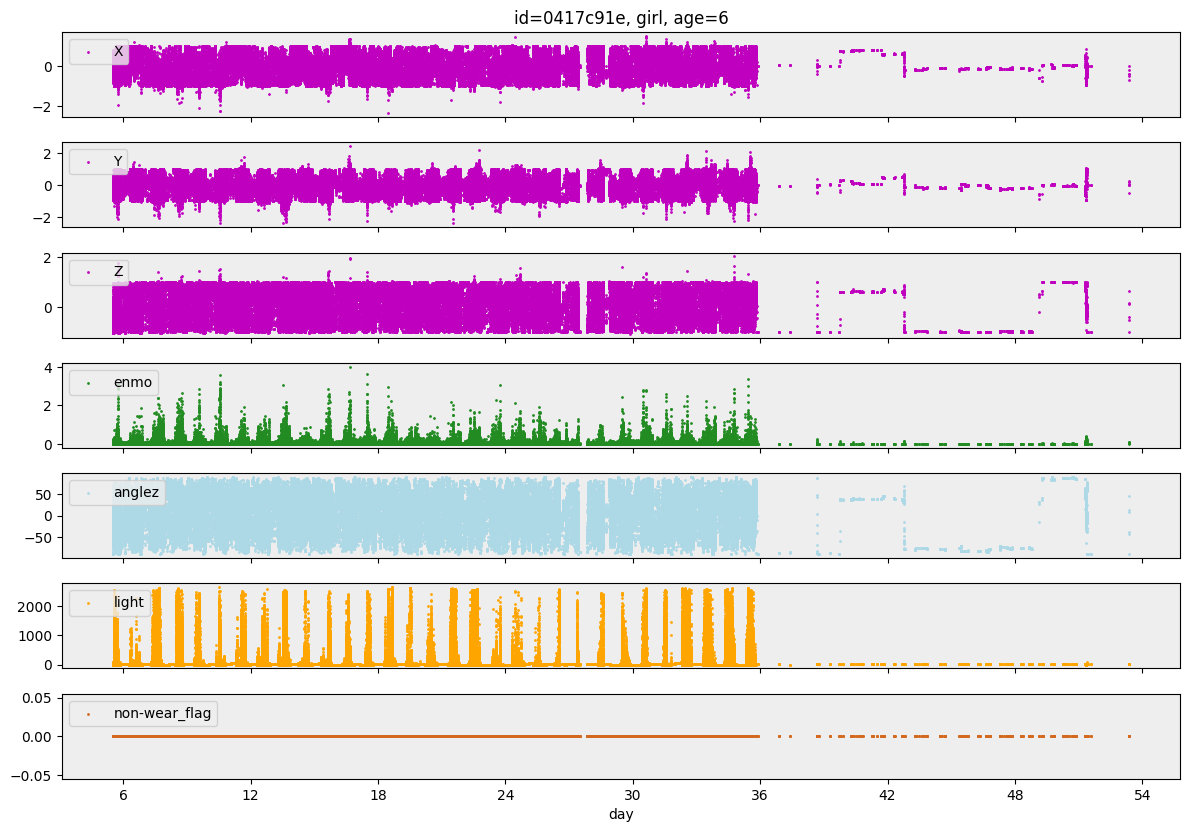

In [15]:
analyze_actigraphy(actigraphy, only_one_week=False)

# **Feature Engineering**

## Load the file

In [16]:
# Load the time series files (actigraphy files)

# Feature Extraction:
# Transform time series data into statistical features by calculating the describe() of time series data for each id

from concurrent.futures import ThreadPoolExecutor

def process_file(filename, dirname):
    df = spark.read.parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df = df.drop('step') # drop useless column 'step'

    # Since we have 12 features in each actigraphy file, and Spark's describe() has 5 statistics for each feature, we totally get 60 statistical features for each id.
    stats = df.describe().collect()

    flattened_stats = [] # flatten the 5*12 stats into 1*60, which can be seen as a row
    for row in stats:
        flattened_stats.extend([float(value) for value in list(row.asDict().values())[1:]])

    # return the list of the 60 statistical features and the id of the actigraphy file
    return flattened_stats, filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)

    results = []
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    stat_columns = [f"stat_{i}" for i in range(len(stats[0]))] # from stat_0 to stat_59

    # print(stats[:1])
    # print(stat_columns)

    stats_rdd = spark.sparkContext.parallelize([(index, *stat) for index, stat in zip(indexes, stats)])
    stats_df = spark.createDataFrame(stats_rdd, schema=['id'] + stat_columns)

    # stats_df.show(5)
    return stats_df

In [17]:
train_ts = load_time_series(f'{data_path}/series_train.parquet')
test_ts = load_time_series(f'{data_path}/series_test.parquet')

100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


In [ ]:
train_ts.toPandas().to_csv('tr.csv')
test_ts.toPandas().to_csv('te.csv')

In [31]:
train_df = pd.read_csv('tr.csv')
test_df = pd.read_csv('te.csv')

train_df = train_df.drop(columns=train_df.columns[0])
test_df = test_df.drop(columns=test_df.columns[0])

train_ts = spark.createDataFrame(train_df)
test_ts = spark.createDataFrame(test_df)

In [32]:
train_ts.show()

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+----------+----------+-----------+-------+----------+-------+-------+---------+--------+-------+-------+-------+----------+----------+---------+----------+---------+-------+-------+-------+---------+-------+-------+-------+
|      id|  stat_0|  stat_1|  stat_2|  stat_3|  stat_4|  stat_5|  stat_6|  stat_7|  stat_8|  stat_9| stat_10| stat_11|            stat_12|            stat_13|            stat_14|           stat

## Dimension Reduction

In [34]:
# We do dimension reduction because the statistical features in train_ts/test_ts are too many.
# We reduct the dimension from 60 to 36 by using autoencoder.

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [35]:
def perform_autoencoder(df, encoding_dim=36, epochs=100, batch_size=32):
    feature_columns = df.columns
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df = assembler.transform(df)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaler_model = scaler.fit(df)
    df_scaled = scaler_model.transform(df)

    scaled_data = df_scaled.select("scaled_features").rdd.map(lambda row: row['scaled_features'].toArray()).collect()
    data_tensor = torch.FloatTensor(scaled_data)

    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor)

    encoded_data = encoded_data.tolist()
    schema = StructType([StructField(f"Enc_{i}", DoubleType(), True) for i in range(len(encoded_data[0]))])
    df_encoded = spark.createDataFrame([Row(*row) for row in encoded_data], schema=schema)

    return df_encoded

In [36]:
train_ts_noid = train_ts.drop('id')
test_ts_noid = test_ts.drop('id')

In [37]:
train_ts_encoded = perform_autoencoder(train_ts_noid, encoding_dim=36, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(test_ts_noid, encoding_dim=36, epochs=100, batch_size=32)

C:\Users\akits\AppData\Local\Temp\ipykernel_7216\3626830297.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data_tensor = torch.FloatTensor(scaled_data)


Epoch [10/100], Loss: 0.6836]
Epoch [20/100], Loss: 0.6074]
Epoch [30/100], Loss: 0.5878]
Epoch [40/100], Loss: 0.5832]
Epoch [50/100], Loss: 0.5801]
Epoch [60/100], Loss: 0.5743]
Epoch [70/100], Loss: 0.5711]
Epoch [80/100], Loss: 0.5723]
Epoch [90/100], Loss: 0.5752]
Epoch [100/100], Loss: 0.5695]
Epoch [10/100], Loss: 0.6750]
Epoch [20/100], Loss: 0.6730]
Epoch [30/100], Loss: 0.6709]
Epoch [40/100], Loss: 0.6685]
Epoch [50/100], Loss: 0.6656]
Epoch [60/100], Loss: 0.6620]
Epoch [70/100], Loss: 0.6571]
Epoch [80/100], Loss: 0.6502]
Epoch [90/100], Loss: 0.6401]
Epoch [100/100], Loss: 0.6248]


In [38]:
train_ts_encoded.toPandas().to_csv('train_ts_encoded.csv',index=False)
test_ts_encoded.toPandas().to_csv('test_ts_encoded.csv',index=False)

In [40]:
train_ts_encoded = spark.createDataFrame(pd.read_csv('train_ts_encoded.csv'))
test_ts_encoded = spark.createDataFrame(pd.read_csv('test_ts_encoded.csv'))

In [41]:
test_ts_encoded.show()

+------------------+-----+------------------+------------------+------------------+------------------+------------------+------------------+-----+-----+------------------+------------------+------------------+------------------+------+------+------------------+------------------+------+------------------+------------------+------------------+------+----------------+------+------+------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------+
|             Enc_0|Enc_1|             Enc_2|             Enc_3|             Enc_4|             Enc_5|             Enc_6|             Enc_7|Enc_8|Enc_9|            Enc_10|            Enc_11|            Enc_12|            Enc_13|Enc_14|Enc_15|            Enc_16|            Enc_17|Enc_18|            Enc_19|            Enc_20|            Enc_21|Enc_22|          Enc_23|Enc_24|Enc_25|Enc_26|            Enc_27|            Enc_28|            Enc_29|   

## Merge train and train_tf

In [42]:
# Put 'id' column back to train_ts_encoded/test_ts_encoded

train_ts_encoded_1 = train_ts_encoded.withColumn("index", F.monotonically_increasing_id())
train_ts_1 = train_ts.withColumn("index", F.monotonically_increasing_id())
train_ts_encoded_2 = train_ts_encoded_1.join(train_ts_1.select("index", "id"), on="index", how="inner").drop("index")

test_ts_encoded_1 = test_ts_encoded.withColumn("index", F.monotonically_increasing_id())
test_ts_1 = test_ts.withColumn("index", F.monotonically_increasing_id())
test_ts_encoded_2 = test_ts_encoded_1.join(test_ts_1.select("index", "id"), on="index", how="inner").drop("index")

In [43]:
train_ts_encoded = train_ts_encoded_2
test_ts_encoded = test_ts_encoded_2

Merge based on 'id' col

In [44]:
train = train.join(train_ts_encoded, on="id", how="left")
test = test.join(test_ts_encoded, on="id", how="left")

In [45]:
print(train.dtypes)

[('id', 'string'), ('Basic_Demos-Enroll_Season', 'string'), ('Basic_Demos-Age', 'int'), ('Basic_Demos-Sex', 'int'), ('CGAS-Season', 'string'), ('CGAS-CGAS_Score', 'int'), ('Physical-Season', 'string'), ('Physical-BMI', 'double'), ('Physical-Height', 'double'), ('Physical-Weight', 'double'), ('Physical-Waist_Circumference', 'double'), ('Physical-Diastolic_BP', 'int'), ('Physical-HeartRate', 'int'), ('Physical-Systolic_BP', 'int'), ('Fitness_Endurance-Season', 'string'), ('Fitness_Endurance-Max_Stage', 'int'), ('Fitness_Endurance-Time_Mins', 'int'), ('Fitness_Endurance-Time_Sec', 'int'), ('FGC-Season', 'string'), ('FGC-FGC_CU', 'int'), ('FGC-FGC_CU_Zone', 'int'), ('FGC-FGC_GSND', 'double'), ('FGC-FGC_GSND_Zone', 'int'), ('FGC-FGC_GSD', 'double'), ('FGC-FGC_GSD_Zone', 'int'), ('FGC-FGC_PU', 'int'), ('FGC-FGC_PU_Zone', 'int'), ('FGC-FGC_SRL', 'double'), ('FGC-FGC_SRL_Zone', 'int'), ('FGC-FGC_SRR', 'double'), ('FGC-FGC_SRR_Zone', 'int'), ('FGC-FGC_TL', 'double'), ('FGC-FGC_TL_Zone', 'int'),

In [46]:
train.show()

+--------+-------------------------+---------------+---------------+-----------+---------------+---------------+------------+---------------+---------------+----------------------------+---------------------+------------------+--------------------+------------------------+---------------------------+---------------------------+--------------------------+----------+----------+---------------+------------+-----------------+-----------+----------------+----------+---------------+-----------+----------------+-----------+----------------+----------+---------------+----------+--------------------------+-----------+-----------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------------+-----------+-----------+-----------+-----------+-----------+------------+-----------------+------------+-----------------+------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------

## Fill the missing values

In [47]:
numeric_cols = [col for col, dtype in train.dtypes if dtype in ('int', 'double')]

# temporarily transform to pandas because spark cannot fit KNNImputer
train_numeric = train.select(numeric_cols).toPandas()

imputer = KNNImputer(n_neighbors=5) # fill by KNNImputer
imputed_data = imputer.fit_transform(train_numeric)

# transform back to spark
train_imputed_numeric = spark.createDataFrame(pd.DataFrame(imputed_data, columns=numeric_cols))

train_imputed_numeric = train_imputed_numeric.withColumn('sii', F.round(F.col('sii')).cast(IntegerType()))

# merge numerical columns with non-numerical columns
train_numeric_indexed = train_imputed_numeric.withColumn("index", F.monotonically_increasing_id())
train_indexed = train.withColumn("index", F.monotonically_increasing_id())
train_imputed = train_numeric_indexed.join(train_indexed.select("index", *[col for col in train.columns if col not in numeric_cols]), on="index", how="inner").drop("index")


In [48]:
train = train_imputed

In [51]:
train.show()

+---------------+---------------+---------------+------------+-----------------+------------------+----------------------------+---------------------+------------------+--------------------+---------------------------+---------------------------+--------------------------+----------+---------------+------------------+-----------------+------------------+----------------+----------+---------------+-----------+----------------+-----------+----------------+----------+---------------+--------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--

## Generate some new features

You can just build new feature_enginnering function

In [ ]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(*season_cols)

    df = df.withColumn('BMI_Age', F.col('Physical-BMI') * F.col('Basic_Demos-Age'))
    df = df.withColumn('Internet_Hours_Age', F.col('PreInt_EduHx-computerinternet_hoursday') * F.col('Basic_Demos-Age'))
    df = df.withColumn('BMI_Internet_Hours', F.col('Physical-BMI') * F.col('PreInt_EduHx-computerinternet_hoursday'))
    df = df.withColumn('BFP_BMI', F.col('BIA-BIA_Fat') / F.col('BIA-BIA_BMI'))
    df = df.withColumn('FFMI_BFP', F.col('BIA-BIA_FFMI') / F.col('BIA-BIA_Fat'))
    df = df.withColumn('FMI_BFP', F.col('BIA-BIA_FMI') / F.col('BIA-BIA_Fat'))
    df = df.withColumn('LST_TBW', F.col('BIA-BIA_LST') / F.col('BIA-BIA_TBW'))
    df = df.withColumn('BFP_BMR', F.col('BIA-BIA_Fat') * F.col('BIA-BIA_BMR'))
    df = df.withColumn('BFP_DEE', F.col('BIA-BIA_Fat') * F.col('BIA-BIA_DEE'))
    df = df.withColumn('BMR_Weight', F.col('BIA-BIA_BMR') / F.col('Physical-Weight'))
    df = df.withColumn('DEE_Weight', F.col('BIA-BIA_DEE') / F.col('Physical-Weight'))
    df = df.withColumn('SMM_Height', F.col('BIA-BIA_SMM') / F.col('Physical-Height'))
    df = df.withColumn('Muscle_to_Fat', F.col('BIA-BIA_SMM') / F.col('BIA-BIA_FMI'))
    df = df.withColumn('Hydration_Status', F.col('BIA-BIA_TBW') / F.col('Physical-Weight'))
    df = df.withColumn('ICW_TBW', F.col('BIA-BIA_ICW') / F.col('BIA-BIA_TBW'))

    return df

In [53]:
train = feature_engineering(train)
train = train.dropna(thresh=10)
test = feature_engineering(test)

TypeError: 'str' object is not callable

## Try Training



In [ ]:
from sklearn.metrics import cohen_kappa_score
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.classification import LogisticRegression
from scipy.optimize import minimize

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit

In [ ]:
# Get the list of columns that contain 'PCIAT' as no 'PCIAT' in test_df
pciat_cols = [col for col in train.columns if 'PCIAT' in col]

# Drop the PCIAT columns from the DataFrame
train = train.drop(*pciat_cols)

In [ ]:
train_noid = train.drop('id')

In [ ]:
# evaluation score
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [ ]:
feature_cols = [col for col in train_noid.columns if col != 'sii']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features', handleInvalid='skip')



In [ ]:
log_reg = LogisticRegression(featuresCol='features', labelCol='sii')

# Creating the pipeline
pipeline = Pipeline(stages=[assembler, log_reg])

In [ ]:
train_try, val_try = train_noid.randomSplit([0.8,0.2])

# Fitting the model on training data
fit_model = pipeline.fit(train_try)

# Storing the results on test data
results = fit_model.transform(val_try)

# Showing the results
results.show()

In [ ]:
y_true = results.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = results.select("prediction").rdd.flatMap(lambda x: x).collect()

In [ ]:
qwk_score = quadratic_weighted_kappa(y_true, y_pred)
print("Quadratic Weighted Kappa:", qwk_score)